In [4]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob as gb
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
IMAGE_SIZE = (64,64)
BATCH_SIZE = 1
CHANNELS = 3

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/corn-or-maize-leaf-disease-dataset/data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE 
)

Found 4188 files belonging to 4 classes.


In [7]:
path ="/kaggle/input/corn-or-maize-leaf-disease-dataset/data"
size=[]
for folder in os.listdir(path):
    files = gb.glob(pathname=str(path+"//"+folder+"/*.jpg"))
    for file in files:
        image=plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(256, 256, 3)      1323
(768, 1024, 3)        8
(1200, 675, 3)        7
(2448, 3264, 3)       7
(900, 1200, 3)        5
                   ... 
(1024, 650, 3)        1
(640, 360, 3)         1
(371, 788, 3)         1
(200, 250, 3)         1
(378, 420, 3)         1
Length: 265, dtype: int64

In [8]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [9]:
len(dataset)

4188

In [10]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
train_ds,val_ds,test_ds = get_dataset(dataset)


In [11]:
print(f"There are {len(train_ds)} train_ds.\n")
print(f"There are {len(val_ds)} val_ds.\n")
print(f"There are {len(test_ds)}  test_ds.\n")

There are 3350 train_ds.

There are 418 val_ds.

There are 420  test_ds.



In [13]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(64,64),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [51]:
n_classes = 4
BATCH_SIZE=32
input_shape = (BATCH_SIZE,64,64,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(10,(3,3),activation ='relu',input_shape=input_shape),
    layers.MaxPooling2D(10,(2,2)),
    layers.Conv2D(20,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D(20,(2,2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape=input_shape)


In [52]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 10)        280       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 27, 27, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 20)        1820      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 3, 3, 20)         0         
 g2D)                                                 

In [54]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [55]:
history = model.fit(
train_ds,
epochs=30
    ,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/30
3350/3350 [==============================] - 39s 8ms/step - loss: 0.6319 - accuracy: 0.7469 - val_loss: 1.0388 - val_accuracy: 0.5670
Epoch 2/30
3350/3350 [==============================] - 37s 9ms/step - loss: 0.5603 - accuracy: 0.7687 - val_loss: 0.3445 - val_accuracy: 0.8493
Epoch 3/30
3350/3350 [==============================] - 34s 8ms/step - loss: 0.4372 - accuracy: 0.8212 - val_loss: 0.3614 - val_accuracy: 0.8325
Epoch 4/30
3350/3350 [==============================] - 34s 8ms/step - loss: 0.4334 - accuracy: 0.8242 - val_loss: 0.4223 - val_accuracy: 0.8541
Epoch 5/30
3350/3350 [==============================] - 37s 9ms/step - loss: 0.4170 - accuracy: 0.8227 - val_loss: 0.4083 - val_accuracy: 0.8230
Epoch 6/30
3350/3350 [==============================] - 35s 8ms/step - loss: 0.4345 - accuracy: 0.8167 - val_loss: 0.4168 - val_accuracy: 0.8493
Epoch 7/30
3350/3350 [==============================] - 35s 8ms/step - loss: 0.4250 - accuracy: 0.8239 - val_loss: 0.5464 - val_ac

In [56]:
scores = model.evaluate(test_ds)

420/420 [==============================] - 7s 3ms/step - loss: 0.3559 - accuracy: 0.8619


In [57]:
history

In [58]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 3350}

In [59]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

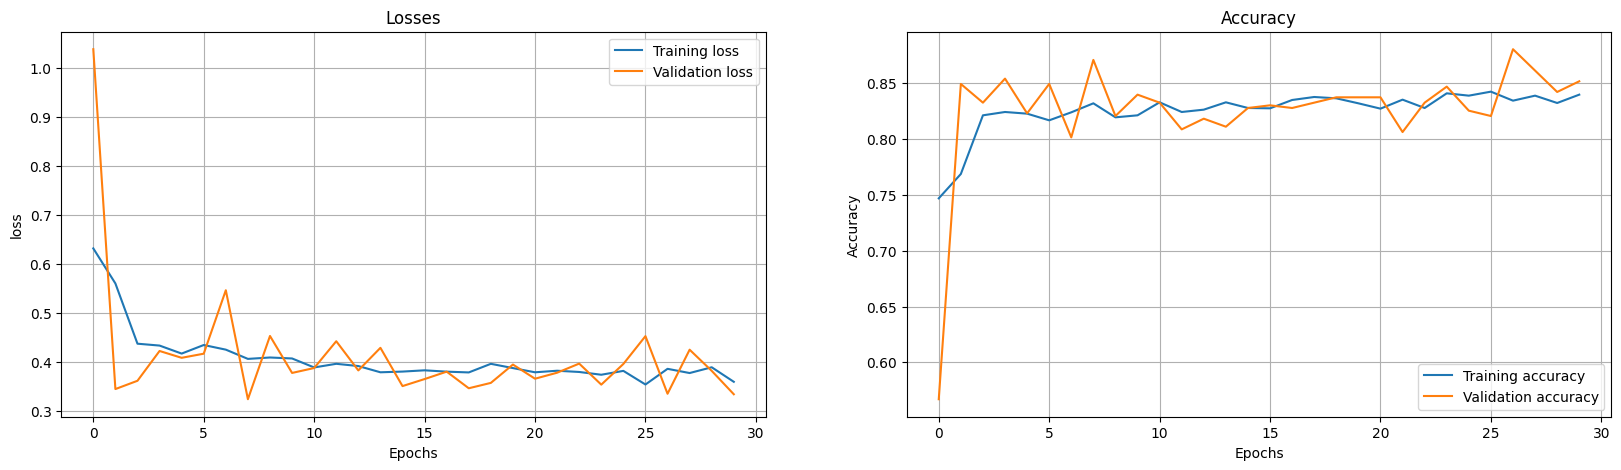

In [60]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

First Image to Predict :

Actual label: Common_Rust
1/1 [==============================] - 0s 108ms/step

Predicted label Common_Rust


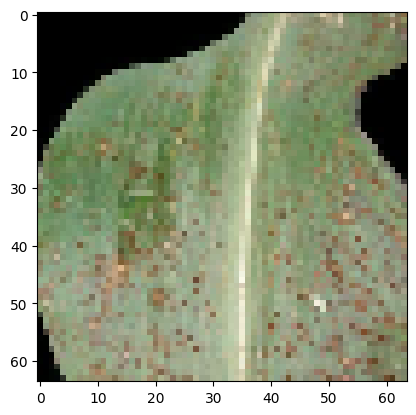

In [61]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model. predict (images_batch) 
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [62]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

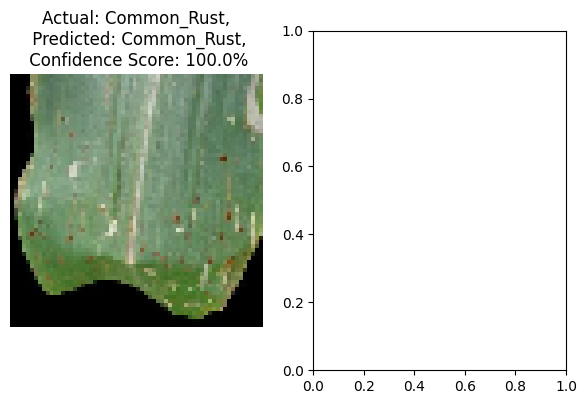

In [49]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [ ]:
# model_version = 4
model.save('/kaggle/working/  paper111')